In [14]:
import ROOT
from ROOT import gStyle
import numpy as np
import ctypes
import os
import pandas as pd

def biner(o_bin,m_bin,f_bin,f_step,l_step):
    a=np.arange(o_bin,m_bin,f_step)
    b=np.arange(m_bin,f_bin+l_step,l_step)
    return np.concatenate((a,b))

def normalization(hist_list,norm_bin):
    for hist in hist_list:
        for i in range(1,hist.GetNbinsX()+2):
            value=hist.GetBinContent(i)
            error=hist.GetBinError(i)
            sf=hist.GetBinWidth(i)/norm_bin
            hist.SetBinContent(i,value/sf)
            hist.SetBinError(i,error/sf)

In [15]:
##### SELECTING GENERATOR FOR SIGNAL SAMPLE
signal_sample="Signal_Sherpa.root"
qcd_sample='Zee_Sherpa.root'
type_of_mc = qcd_sample.strip('.root').split('_')[1]

#### CREATING THE CORRESPONDING MC.ROOT FILE EVERYTIME YOU CHANGE THE SIGNAL SAMPLE

os.system("rm BG.root MC.root")
os.system('hadd BG.root VV.root singletop.root Wjets.root Ztautau_PoPy.root ttbar.root Zmumu.root '+qcd_sample)
os.system("hadd MC.root "+"BG.root "+signal_sample)

0

hadd Target file: MC.root
hadd compression setting for all output: 1
hadd Source file 1: BG.root
hadd Source file 2: Signal_Sherpa.root
hadd Target path: MC.root:/


In [16]:
histos_no_rebin={
"delta_phi":[],
"n_bjets":[],
"lepiso":[],
"n_jets_interval":[],
"lep1_eta_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[],
"lep2_eta_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[],
"delta_R_leplep_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[],
"delta_R_lep1jet_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[],
"delta_R_lep2jet_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[],

}
histos_rebin={
"lep1_pt":[120,5,10],
"lep2_pt":[120,5,10],
"ljet0_pt":[120,5,10],
"ljet1_pt":[120,5,10],
"pt_bal":[0.3,0.02,0.1],
"Z_centrality":[2,0.1,0.5],
"delta_y":[4,0.1,0.5],
"inv_mass":[120,5,10],
"mass_jj":[1500,250,500],
}
histos={}
histos.update(histos_no_rebin)
histos.update(histos_rebin)
    
    
for i in histos:
    print(i)
    MC=ROOT.TFile.Open("MC.root","READ")
    Data = ROOT.TFile.Open("Data.root","READ")
    Signal=ROOT.TFile.Open(signal_sample,"READ")
    VV=ROOT.TFile.Open("VV.root","READ")
    Wjets=ROOT.TFile.Open("Wjets.root","READ")
    Zee=ROOT.TFile.Open(qcd_sample,"READ")
    Ttbar=ROOT.TFile.Open("ttbar.root","READ")
    SingleTop=ROOT.TFile.Open("singletop.root","READ")

    a=i
    
    mc=MC.Get(a)
    data=Data.Get(a)
    signal=Signal.Get(a)
    vv=VV.Get(a)
    w=Wjets.Get(a)
    zee=Zee.Get(a)
    tt=Ttbar.Get(a)
    t=SingleTop.Get(a)
    
    mc.SetDirectory(0)
    signal.SetDirectory(0)
    data.SetDirectory(0)
    vv.SetDirectory(0)
    w.SetDirectory(0)
    zee.SetDirectory(0)
    tt.SetDirectory(0)
    t.SetDirectory(0)
    
    MC.Close()
    Signal.Close()
    Data.Close()
    VV.Close()
    Wjets.Close()
    Zee.Close()
    Ttbar.Close()
    SingleTop.Close()

    hs = ROOT.THStack("hs","")
    
    s=data.GetXaxis().GetBinLowEdge(1)
    e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
    
    if i in histos_rebin:
        ob=data.GetNbinsX()
        s=data.GetXaxis().GetBinLowEdge(1)
        e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
        rebining=biner(s,histos[i][0],e,histos[i][1],histos[i][2])
        nb=len(rebining)-1
        mc=mc.Rebin(nb,"mc",rebining)
        signal=signal.Rebin(nb,"signal",rebining)
        data=data.Rebin(nb,"data",rebining)
        vv=vv.Rebin(nb,"vv",rebining)
        tt=tt.Rebin(nb,"tt",rebining)
        t=t.Rebin(nb,"t",rebining)
        zee=zee.Rebin(nb,"zee",rebining)
        w=w.Rebin(nb,"w",rebining)
        
        if histos[i][1]!=histos[i][2]:
            hist_list=[signal,data,vv,tt,t,zee,w,mc]
            normalization(hist_list,histos[i][1])

    signal.SetFillColor(ROOT.kOrange+7)
    signal.SetLineWidth(0)
    w.SetFillColor(ROOT.kGreen)
    w.SetLineColor(ROOT.kGreen+1)
    zee.SetFillColor(ROOT.kViolet)
    zee.SetLineColor(ROOT.kViolet+1)
    zee.SetLineWidth(0)
    vv.SetFillColor(ROOT.kBlue)
    vv.SetLineColor(ROOT.kBlue+1)
    tt.SetFillColor(ROOT.kYellow)
    tt.SetLineColor(ROOT.kYellow+1)
    t.SetFillColor(ROOT.kCyan)
    t.SetLineColor(ROOT.kCyan+1)
    data.SetLineColor(ROOT.kBlack)
    data.SetMarkerStyle(20)
    data.SetMarkerSize(0.5)

    hs.Add(vv)
    hs.Add(w)
    hs.Add(tt)
    hs.Add(t)
    hs.Add(zee)
    hs.Add(signal)

    ratio=mc.Clone()
    ratio.Divide(data)
    
    ratio_bg_mc=mc.Clone()
    ratio_bg_mc.Add(signal,-1)
    ratio_bg_mc.Divide(mc)

    gStyle.SetOptStat(1111111)
    gStyle.SetStatY(0.97);                
    gStyle.SetStatX(1.0);
    gStyle.SetStatW(0.12);                
    gStyle.SetStatH(0.12);

    canvas3 = ROOT.TCanvas("canvas3")
    canvas3.cd()

    ##### DRAWING TOP PAD, SETTING MARGINS #######

    pad1 = ROOT . TPad (" pad1 "," pad1 " ,0 ,0.35 ,1 ,1)
    pad1.SetTopMargin(0.03)
    pad1.SetRightMargin(0.03)
    pad1.SetLeftMargin(0.08)
    pad1.SetBottomMargin(0.0)
    pad1.Draw ()
    pad1.cd ()

    ###### SETTING STATS BOX POSITION ######
    
    gStyle.SetStatY(0.93);                
    gStyle.SetStatX(0.99);
    gStyle.SetStatW(0.1);                
    gStyle.SetStatH(0.1);


    data.Draw("pe")
    hs.Draw("HIST same")
    data.Draw("pe same")
    data.Draw("sameaxis")
    
    pad1.SetLogy()


    data . GetYaxis (). SetRangeUser (1 ,10*data.GetBinContent(data.GetMaximumBin()))
    data . GetXaxis (). SetRangeUser (s,e)

    hs . GetXaxis (). SetRangeUser (20e3 ,30e4)
    hs . GetYaxis (). SetRangeUser (0 ,40)
    legend = ROOT . TLegend (0.45 ,0.80 ,0.85 ,0.95)
    legend . AddEntry ( vv ,"Diboson")
    legend . AddEntry ( data ," Data ")
    legend . AddEntry ( signal ," Signal ")
    legend . AddEntry ( w ," W+jets ")
    legend . AddEntry ( zee ," QCD-Zee ")
    legend . AddEntry ( t ," Single top ")
    legend . AddEntry ( tt ," ttbar ")
    legend.SetNColumns(3)
    gStyle.SetLegendBorderSize(0)
    legend . SetLineWidth (0)
    legend . Draw ()

    data.SetTitle("")
    l=ROOT.TLatex()
    l.SetNDC ()
    l.DrawLatex(0.9,0.7,"Z#rightarrow ee")

    canvas3.cd()
    pad2 = ROOT . TPad (" pad2 "," pad2 " ,0 ,0.15 ,1 ,0.35)
    pad2.SetRightMargin(0.03)
    pad2.SetLeftMargin(0.08)
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.0)
    pad2.Draw ()
    pad2.cd ()
    ratio.Draw ("pe")
    ratio.SetTitle("")
    ratio.SetStats(0)
    ratio . GetYaxis (). SetRangeUser (0.5 ,1.5)
    ratio . GetXaxis (). SetRangeUser (s ,e)
    ratio . GetYaxis (). SetTitle ("DATA/MC")
    ratio . GetYaxis (). SetTitleSize (0.15)
    ratio . GetYaxis (). SetTitleOffset (0.25)
    #ratio . GetXaxis (). SetTitle (histos[i][3])
    ratio . GetXaxis (). SetTitleSize (0.09)
    ratio.GetXaxis().SetLabelSize(0.10)
    ratio.GetYaxis().SetLabelSize(0.08)
        

    ###### SETTING ALL THE HORIZONTAL DASHED LINES #######
    
    line = ROOT . TLine (s ,1 ,e,1)
    line . SetLineColor ( ROOT . kBlack )
    line . SetLineWidth (2)
    line2 = ROOT . TLine (s ,1.1 ,e,1.1)
    line2 . SetLineColor ( ROOT . kBlack )
    line2 . SetLineWidth (1)
    line2 . SetLineStyle(2)
    line3 = ROOT . TLine (s ,0.9 ,e,0.9)
    line3 . SetLineColor ( ROOT . kBlack )
    line3 . SetLineWidth (1)
    line3 . SetLineStyle(2)
    line4 = ROOT . TLine (s ,1.2 ,e,1.2)
    line4 . SetLineColor ( ROOT . kBlack )
    line4 . SetLineWidth (1)
    line4 . SetLineStyle(2)
    line5 = ROOT . TLine (s ,0.8 ,e,0.8)
    line5 . SetLineColor ( ROOT . kBlack )
    line5 . SetLineWidth (1)
    line5 . SetLineStyle(2)
    line6 = ROOT . TLine (s ,1.3 ,e,1.3)
    line6 . SetLineColor ( ROOT . kBlack )
    line6 . SetLineWidth (1)
    line6 . SetLineStyle(2)
    line7 = ROOT . TLine (s ,0.7 ,e,0.7)
    line7 . SetLineColor ( ROOT . kBlack )
    line7 . SetLineWidth (1)
    line7 . SetLineStyle(2)
    line8 = ROOT . TLine (s ,1.4 ,e,1.4)
    line8 . SetLineColor ( ROOT . kBlack )
    line8 . SetLineWidth (1)
    line8 . SetLineStyle(2)
    line9 = ROOT . TLine (s ,0.6 ,e,0.6)
    line9 . SetLineColor ( ROOT . kBlack )
    line9 . SetLineWidth (1)
    line9 . SetLineStyle(2)
    line . Draw (" same ")
    line2 . Draw (" same ")
    line3 . Draw (" same ")
    line4 . Draw (" same ")
    line5 . Draw (" same ")
    line6 . Draw (" same ")
    line7 . Draw (" same ")
    line8 . Draw (" same ")
    line9 . Draw (" same ")
    line . Draw (" same ")
    
    canvas3.cd()
    pad3 = ROOT . TPad (" pad3","pad3" ,0 ,0.00 ,1 ,0.15)
    pad3.SetRightMargin(0.03)
    pad3.SetLeftMargin(0.08)
    pad3.SetTopMargin(0)
    pad3.SetBottomMargin(0.1)
    pad3.Draw ()
    pad3.cd ()
    ratio_bg_mc.SetStats(0)
    ratio_bg_mc . GetYaxis (). SetRangeUser (0.88 ,1.02)
    ratio_bg_mc . GetXaxis (). SetRangeUser (s ,e)
    ratio_bg_mc . GetYaxis (). SetTitle ("BG/MC")
    ratio_bg_mc . GetYaxis (). SetTitleSize (0.15)
    ratio_bg_mc . GetYaxis (). SetTitleOffset (0.25)
    ratio_bg_mc.GetYaxis().SetLabelSize(0.09)
    ratio_bg_mc.GetXaxis().SetLabelSize(0.12)
    ratio_bg_mc.SetMarkerStyle(8)
    ratio_bg_mc.SetMarkerSize(0.6)
    
    ratio_bg_mc.Draw ("hist p")
    ###### SETTING ALL THE HORIZONTAL DASHED LINES #######
    
    line10 = ROOT . TLine (s ,0.98 ,e,0.98)
    line10 . SetLineColor ( ROOT . kBlack )
    line10 . SetLineWidth (1)
    line10 . SetLineStyle(2)
    line11 = ROOT . TLine (s ,0.96 ,e,0.96)
    line11 . SetLineColor ( ROOT . kBlack )
    line11 . SetLineWidth (1)
    line11 . SetLineStyle(2)
    line12 = ROOT . TLine (s ,0.94 ,e,0.94)
    line12 . SetLineColor ( ROOT . kBlack )
    line12 . SetLineWidth (1)
    line12 . SetLineStyle(2)
    line13 = ROOT . TLine (s ,0.92 ,e,0.92)
    line13 . SetLineColor ( ROOT . kBlack )
    line13 . SetLineWidth (1)
    line13 . SetLineStyle(2)
    line14 = ROOT . TLine (s ,0.90 ,e,0.90)
    line14 . SetLineColor ( ROOT . kBlack )
    line14 . SetLineWidth (1)
    line14 . SetLineStyle(2)
    sline = ROOT . TLine (s ,1 ,e,1)
    sline . SetLineColor ( ROOT . kBlack )
    sline . SetLineWidth (2)
    sline.Draw("same")
    line10 . Draw (" same ")
    line11 . Draw (" same ")
    line12 . Draw (" same ")
    line13 . Draw (" same ")
    line14 . Draw (" same ")




    canvas3.Print(a+"_"+type_of_mc+".pdf")
    if i=="ratio_lpt_tpt_cuts_ptl":
        dic={"data":data,"signal":signal,"vv":vv,"w":w,"z":z,"tt":tt,"t":t}
        dic_numbers={"data":[0,0],"signal":[0,0],"vv":[0,0],"w":[0,0],"z":[0,0],"tt":[0,0],"t":[0,0]}
        for i in dic:
            error=ctypes.c_double()
            a=dic[i].IntegralAndError(0,1000,error)
            dic_numbers[i][0]=a
            dic_numbers[i][1]=error.value
        dataframe=pd.DataFrame.from_dict(dic_numbers, orient='index',columns=['Yield', 'Stat. Uncer'])
        display(dataframe.round(decimals=3))




delta_phi
n_bjets
lepiso
n_jets_interval
lep1_eta_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl
lep2_eta_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl
delta_R_leplep_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl
delta_R_lep1jet_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl
delta_R_lep2jet_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl
lep1_pt
lep2_pt
ljet0_pt
ljet1_pt
pt_bal
Z_centrality
delta_y
inv_mass
mass_jj


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Info in <TCanvas::Print>: pdf file delta_phi.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Info in <TCanvas::Print>: pdf file n_bjets.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Info in <TCanvas::Print>: pdf file lepiso.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Info in <TCanvas::Print>: pdf file n_jets_interval.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Info in <TCanvas::Print>: pdf file lep1_eta_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Info in <TCanvas::Print>: pdf file lep2_eta_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl.pdf has been created
Warning in <T

In [9]:
import os

histo={
"mass_jj":[1500,250,500],
}

def ratio_subtracted_plot(path_to_samples=os.getcwd(),signal_name="Signal",data_name="Data",bg_names=[],histogram_info=None):
    
    MC = ROOT.TFile.Open(path_to_samples+"/"+"MC"+".root","READ")
    Data = ROOT.TFile.Open(path_to_samples+"/"+data_name+".root","READ")
    Signal = ROOT.TFile.Open(path_to_samples+"/"+signal_name+".root","READ")
    
    bg_files_list=[]
    for i in bg_names:
        bg_files_list.append(ROOT.TFile.Open(path_to_samples+"/"+i+".root","READ"))
    
    histogram_name = list(histogram_info.keys())[0]

    mc=MC.Get(histogram_name)
    data=Data.Get(histogram_name)
    signal=Signal.Get(histogram_name)
    
    bg_histograms_list = [i.Get(histogram_name) for i in bg_files_list]
    
    
    mc.SetDirectory(0)
    signal.SetDirectory(0)
    data.SetDirectory(0)
    
    for i in bg_histograms_list:
        i=i.SetDirectory(0)
    
    MC.Close()
    Signal.Close()
    Data.Close()

    [i.Close() for i in bg_files_list]
    
    s=data.GetXaxis().GetBinLowEdge(1)
    e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
    

    s=data.GetXaxis().GetBinLowEdge(1)
    e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
    rebining=biner(s,histogram_info[histogram_name][0],e,histogram_info[histogram_name][1],histogram_info[histogram_name][2])
    nb=len(rebining)-1
    mc=mc.Rebin(nb,"mc",rebining)
    signal=signal.Rebin(nb,"signal",rebining)
    data=data.Rebin(nb,"data",rebining)
    for i in range(0,len(bg_histograms_list)):
        bg_histograms_list[i]=bg_histograms_list[i].Rebin(nb,bg_names[i],rebining)

    if len(histogram_info[histogram_name])>0:
        hist_list=[signal,data,mc]+bg_histograms_list
        normalization(hist_list,histogram_info[histogram_name][1])
        
    data_subtracted=data.Clone()
    for i in bg_histograms_list:
        data_subtracted.Add(i,-1)
        
        
    ratio=data_subtracted.Clone()
    ratio.Divide(signal)
    
    ###################################################################################################
    
    #######                              Plotting part                                     ############
    
    ###################################################################################################
    
    
    
    gStyle.SetOptStat(1111111)
    gStyle.SetStatY(0.97);                
    gStyle.SetStatX(1.0);
    gStyle.SetStatW(0.12);                
    gStyle.SetStatH(0.12);

    canvas3 = ROOT.TCanvas("canvas3")
    canvas3.cd()

    ##### DRAWING TOP PAD, SETTING MARGINS #######

    pad1 = ROOT . TPad (" pad1 "," pad1 " ,0 ,0.35 ,1 ,1)
    pad1.SetTopMargin(0.03)
    pad1.SetRightMargin(0.03)
    pad1.SetLeftMargin(0.08)
    pad1.SetBottomMargin(0.0)
    pad1.Draw ()
    pad1.cd ()

    ###### SETTING STATS BOX POSITION ######

    gStyle.SetStatY(0.93);                
    gStyle.SetStatX(0.99);
    gStyle.SetStatW(0.1);                
    gStyle.SetStatH(0.1);
    
    data_subtracted.SetLineColor(ROOT.kRed)

    data_subtracted.Draw("pe")
    signal.Draw("HIST same")
    data_subtracted.Draw("same")

    pad1.SetLogy()


    data . GetYaxis (). SetRangeUser (1 ,10*data.GetBinContent(data.GetMaximumBin()))

    legend = ROOT . TLegend (0.45 ,0.80 ,0.85 ,0.95)
    legend . AddEntry ( data_subtracted ," Data subtracted")
    legend . AddEntry ( signal ,signal_name)
    gStyle.SetLegendBorderSize(0)
    legend . SetLineWidth (0)
    legend . Draw ()

    data.SetTitle("")
    l=ROOT.TLatex()
    l.SetNDC ()
    l.DrawLatex(0.9,0.7,"Z#rightarrow #mu#mu")

    canvas3.cd()
    pad2 = ROOT . TPad (" pad2 "," pad2 " ,0 ,0.15 ,1 ,0.35)
    pad2.SetRightMargin(0.03)
    pad2.SetLeftMargin(0.08)
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.0)
    pad2.Draw ()
    pad2.cd ()
    ratio.Draw ("pe")
    ratio.SetTitle("")
    ratio.SetStats(0)
    ratio . GetYaxis (). SetRangeUser (0.1 ,2.0)
    ratio . GetXaxis (). SetRangeUser (s ,e)
    ratio . GetYaxis (). SetTitle ("MC/DATA")
    ratio . GetYaxis (). SetTitleSize (0.15)
    ratio . GetYaxis (). SetTitleOffset (0.25)
    #ratio . GetXaxis (). SetTitle (histos[i][3])
    ratio . GetXaxis (). SetTitleSize (0.09)
    ratio.GetXaxis().SetLabelSize(0.10)
    ratio.GetYaxis().SetLabelSize(0.08)


    ###### SETTING ALL THE HORIZONTAL DASHED LINES #######

    line = ROOT . TLine (s ,1 ,e,1)
    line . SetLineColor ( ROOT . kBlack )
    line . SetLineWidth (2)
    line2 = ROOT . TLine (s ,1.2 ,e,1.2)
    line2 . SetLineColor ( ROOT . kBlack )
    line2 . SetLineWidth (1)
    line2 . SetLineStyle(2)
    line3 = ROOT . TLine (s ,0.8 ,e,0.8)
    line3 . SetLineColor ( ROOT . kBlack )
    line3 . SetLineWidth (1)
    line3 . SetLineStyle(2)
    line4 = ROOT . TLine (s ,1.4 ,e,1.4)
    line4 . SetLineColor ( ROOT . kBlack )
    line4 . SetLineWidth (1)
    line4 . SetLineStyle(2)
    line5 = ROOT . TLine (s ,0.6 ,e,0.6)
    line5 . SetLineColor ( ROOT . kBlack )
    line5 . SetLineWidth (1)
    line5 . SetLineStyle(2)
    line6 = ROOT . TLine (s ,1.6 ,e,1.6)
    line6 . SetLineColor ( ROOT . kBlack )
    line6 . SetLineWidth (1)
    line6 . SetLineStyle(2)
    line7 = ROOT . TLine (s ,0.4 ,e,0.4)
    line7 . SetLineColor ( ROOT . kBlack )
    line7 . SetLineWidth (1)
    line7 . SetLineStyle(2)
    line8 = ROOT . TLine (s ,1.8 ,e,1.8)
    line8 . SetLineColor ( ROOT . kBlack )
    line8 . SetLineWidth (1)
    line8 . SetLineStyle(2)
    line9 = ROOT . TLine (s ,0.2 ,e,0.2)
    line9 . SetLineColor ( ROOT . kBlack )
    line9 . SetLineWidth (1)
    line9 . SetLineStyle(2)
    line . Draw (" same ")
    line2 . Draw (" same ")
    line3 . Draw (" same ")
    line4 . Draw (" same ")
    line5 . Draw (" same ")
    line6 . Draw (" same ")
    line7 . Draw (" same ")
    line8 . Draw (" same ")
    line9 . Draw (" same ")
    line . Draw (" same ")
    
    x_values = []
    y_values = []
    y_uncern = []

    for i in range(1,ratio.GetNbinsX()+1):
        print("m range = ",ratio.GetBinLowEdge(i),"SF = ",round(ratio.GetBinContent(i),3),)
        
        x_values.append(ratio.GetBinLowEdge(i))
        y_values.append(round(ratio.GetBinContent(i),3))
        y_uncern.append(ratio.GetBinError(i))

    canvas3.Print(a+"_"+type_of_mc+"ratio.pdf")
    
    return [x_values,y_values,y_uncern]



m range =  0.0 SF =  1.212
m range =  250.0 SF =  1.124
m range =  500.0 SF =  1.031
m range =  750.0 SF =  1.026
m range =  1000.0 SF =  0.877
m range =  1250.0 SF =  0.817
m range =  1500.0 SF =  0.758
m range =  2000.0 SF =  0.697
m range =  2500.0 SF =  0.714


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Info in <TCanvas::Print>: pdf file mass_jjratio.pdf has been created


[-2.79707270e-04  1.19063154e+00]
-0.00027970727023738154 1.190631543840949
-12.459711064525978 2.2815685001601262


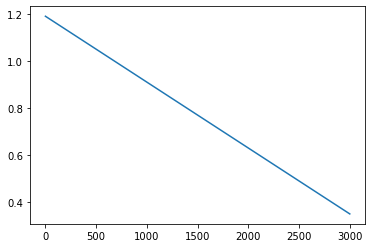

In [10]:
hola=ratio_subtracted_plot(path_to_samples=os.getcwd(),signal_name="Zee_Sherpa",data_name="Data",bg_names=["Signal","VV","Wjets","ttbar","singletop"],histogram_info=histo)
import numpy as np
import matplotlib.pyplot as plt
fit,c = np.polyfit(hola[0][:-1],hola[1][:-1],1,w=1/np.array(hola[2][:-1]),cov='unscaled')
print(fit)
print(fit[0],fit[1])
print(100*np.sqrt(c[0][0])/fit[0],100*np.sqrt(c[1][1])/fit[1])

x=np.linspace(0,3000,13)
y=fit[0]*x+fit[1]

plt.plot(x,y)

### 

### PLOT SUM OF TWO HISTOGRAMS

In [8]:
histo={
"mass_jj":[1500,250,500],
}
histos={}
histos.update(histos_no_rebin)
histos.update(histos_rebin)
    
    

MC=ROOT.TFile.Open("MC.root","READ")
Data = ROOT.TFile.Open("Data.root","READ")
Signal=ROOT.TFile.Open(signal_sample,"READ")
VV=ROOT.TFile.Open("VV.root","READ")
Wjets=ROOT.TFile.Open("Wjets.root","READ")
Zee=ROOT.TFile.Open("Zee_Sherpa.root","READ")
Ttbar=ROOT.TFile.Open("ttbar.root","READ")
SingleTop=ROOT.TFile.Open("singletop.root","READ")

a=list(histo)[0]

mc=MC.Get(a)
data=Data.Get(a)
signal=Signal.Get(a)
vv=VV.Get(a)
w=Wjets.Get(a)
zee=Zee.Get(a)
tt=Ttbar.Get(a)
t=SingleTop.Get(a)

mc.SetDirectory(0)
signal.SetDirectory(0)
data.SetDirectory(0)
vv.SetDirectory(0)
w.SetDirectory(0)
zee.SetDirectory(0)
tt.SetDirectory(0)
t.SetDirectory(0)

MC.Close()
Signal.Close()
Data.Close()
VV.Close()
Wjets.Close()
Zee.Close()
Ttbar.Close()
SingleTop.Close()

s=data.GetXaxis().GetBinLowEdge(1)
e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())

if i in histos_rebin:
    ob=data.GetNbinsX()
    s=data.GetXaxis().GetBinLowEdge(1)
    e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
    rebining=biner(s,histos[i][0],e,histos[i][1],histos[i][2])
    nb=len(rebining)-1
    mc=mc.Rebin(nb,"mc",rebining)
    signal=signal.Rebin(nb,"signal",rebining)
    data=data.Rebin(nb,"data",rebining)
    vv=vv.Rebin(nb,"vv",rebining)
    tt=tt.Rebin(nb,"tt",rebining)
    t=t.Rebin(nb,"t",rebining)
    zee=zee.Rebin(nb,"zee",rebining)
    w=w.Rebin(nb,"w",rebining)

    if histos[i][1]!=histos[i][2]:
        hist_list=[signal,data,vv,tt,t,zee,w,mc]
        normalization(hist_list,histos[i][1])

signal.SetFillColor(ROOT.kWhite)
w.SetFillColor(ROOT.kGreen)
w.SetLineColor(ROOT.kGreen+1)
zee.SetFillColor(ROOT.kViolet)
zee.SetLineColor(ROOT.kViolet+1)
vv.SetFillColor(ROOT.kBlue)
vv.SetLineColor(ROOT.kBlue+1)
tt.SetFillColor(ROOT.kYellow)
tt.SetLineColor(ROOT.kYellow+1)
t.SetFillColor(ROOT.kCyan)
t.SetLineColor(ROOT.kCyan+1)
data.SetLineColor(ROOT.kBlack)



data_subtracted=data.Clone()
data_subtracted.Add(signal,-1)
data_subtracted.Add(w,-1)
data_subtracted.Add(vv,-1)
data_subtracted.Add(tt,-1)
data_subtracted.Add(t,-1)

ratio=data_subtracted.Clone()
ratio.Divide(zee)

gStyle.SetOptStat(1111111)
gStyle.SetStatY(0.97);                
gStyle.SetStatX(1.0);
gStyle.SetStatW(0.12);                
gStyle.SetStatH(0.12);

canvas3 = ROOT.TCanvas("canvas3")
canvas3.cd()

##### DRAWING TOP PAD, SETTING MARGINS #######

pad1 = ROOT . TPad (" pad1 "," pad1 " ,0 ,0.35 ,1 ,1)
pad1.SetTopMargin(0.03)
pad1.SetRightMargin(0.03)
pad1.SetLeftMargin(0.08)
pad1.SetBottomMargin(0.0)
pad1.Draw ()
pad1.cd ()

###### SETTING STATS BOX POSITION ######

gStyle.SetStatY(0.93);                
gStyle.SetStatX(0.99);
gStyle.SetStatW(0.1);                
gStyle.SetStatH(0.1);


data_subtracted.Draw("pe")
zee.Draw("HIST same")
data_subtracted.Draw("same")

pad1.SetLogy()


data . GetYaxis (). SetRangeUser (1 ,10*data.GetBinContent(data.GetMaximumBin()))
data . GetXaxis (). SetRangeUser (s,e)

legend = ROOT . TLegend (0.45 ,0.80 ,0.85 ,0.95)
legend . AddEntry ( data ," Data subtracted")
legend . AddEntry ( zee ," QCD-Zee ")
gStyle.SetLegendBorderSize(0)
legend . SetLineWidth (0)
legend . Draw ()

data.SetTitle("")
l=ROOT.TLatex()
l.SetNDC ()
l.DrawLatex(0.9,0.7,"Z#rightarrow ee")

canvas3.cd()
pad2 = ROOT . TPad (" pad2 "," pad2 " ,0 ,0.15 ,1 ,0.35)
pad2.SetRightMargin(0.03)
pad2.SetLeftMargin(0.08)
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.0)
pad2.Draw ()
pad2.cd ()
ratio.Draw ("pe")
ratio.SetTitle("")
ratio.SetStats(0)
ratio . GetYaxis (). SetRangeUser (0.1 ,2.0)
ratio . GetXaxis (). SetRangeUser (s ,e)
ratio . GetYaxis (). SetTitle ("MC/DATA")
ratio . GetYaxis (). SetTitleSize (0.15)
ratio . GetYaxis (). SetTitleOffset (0.25)
#ratio . GetXaxis (). SetTitle (histos[i][3])
ratio . GetXaxis (). SetTitleSize (0.09)
ratio.GetXaxis().SetLabelSize(0.10)
ratio.GetYaxis().SetLabelSize(0.08)


###### SETTING ALL THE HORIZONTAL DASHED LINES #######

line = ROOT . TLine (s ,1 ,e,1)
line . SetLineColor ( ROOT . kBlack )
line . SetLineWidth (2)
line2 = ROOT . TLine (s ,1.2 ,e,1.2)
line2 . SetLineColor ( ROOT . kBlack )
line2 . SetLineWidth (1)
line2 . SetLineStyle(2)
line3 = ROOT . TLine (s ,0.8 ,e,0.8)
line3 . SetLineColor ( ROOT . kBlack )
line3 . SetLineWidth (1)
line3 . SetLineStyle(2)
line4 = ROOT . TLine (s ,1.4 ,e,1.4)
line4 . SetLineColor ( ROOT . kBlack )
line4 . SetLineWidth (1)
line4 . SetLineStyle(2)
line5 = ROOT . TLine (s ,0.6 ,e,0.6)
line5 . SetLineColor ( ROOT . kBlack )
line5 . SetLineWidth (1)
line5 . SetLineStyle(2)
line6 = ROOT . TLine (s ,1.6 ,e,1.6)
line6 . SetLineColor ( ROOT . kBlack )
line6 . SetLineWidth (1)
line6 . SetLineStyle(2)
line7 = ROOT . TLine (s ,0.4 ,e,0.4)
line7 . SetLineColor ( ROOT . kBlack )
line7 . SetLineWidth (1)
line7 . SetLineStyle(2)
line8 = ROOT . TLine (s ,1.8 ,e,1.8)
line8 . SetLineColor ( ROOT . kBlack )
line8 . SetLineWidth (1)
line8 . SetLineStyle(2)
line9 = ROOT . TLine (s ,0.2 ,e,0.2)
line9 . SetLineColor ( ROOT . kBlack )
line9 . SetLineWidth (1)
line9 . SetLineStyle(2)
line . Draw (" same ")
line2 . Draw (" same ")
line3 . Draw (" same ")
line4 . Draw (" same ")
line5 . Draw (" same ")
line6 . Draw (" same ")
line7 . Draw (" same ")
line8 . Draw (" same ")
line9 . Draw (" same ")
line . Draw (" same ")


canvas3.Print(a+"ratio.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Info in <TCanvas::Print>: pdf file mass_jjratio.pdf has been created
